# 0. Problem statement

In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. In this highly competitive market, the telecommunications industry experiences an average of 15-25% annual churn rate. Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition.

For many incumbent operators, retaining high profitable customers is the number one business
goal. To reduce customer churn, telecom companies need to predict which customers are at high risk of churn. In this project, you will analyze customer-level data of a leading telecom firm, build predictive models to identify customers at high risk of churn, and identify the main indicators of churn.

In this competition, your goal is *to build a machine learning model that is able to predict churning customers based on the features provided for their usage.*

**Customer behaviour during churn:**

Customers usually do not decide to switch to another competitor instantly, but rather over a
period of time (this is especially applicable to high-value customers). In churn prediction, we
assume that there are three phases of customer lifecycle :

1. <u>The ‘good’ phase:</u> In this phase, the customer is happy with the service and behaves as usual.

2. <u>The ‘action’ phase:</u> The customer experience starts to sore in this phase, for e.g. he/she gets a compelling offer from a competitor, faces unjust charges, becomes unhappy with service quality etc. In this phase, the customer usually shows different behaviour than the ‘good’ months. It is crucial to identify high-churn-risk customers in this phase, since some corrective actions can be taken at this point (such as matching the competitor’s offer/improving the service quality etc.)

3. <u>The ‘churn’ phase:</u> In this phase, the customer is said to have churned. In this case, since you are working over a four-month window, the first two months are the ‘good’ phase, the third month is the ‘action’ phase, while the fourth month (September) is the ‘churn’ phase.

# 1. Loading dependencies & datasets

Lets start by loading our dependencies. We can keep adding any imports to this cell block, as we write mode and mode code.

In [311]:
#Data Structures
import pandas as pd
import numpy as np
import re
import os
from joblib import dump, load
from joblib import Parallel, delayed
from IPython.display import display, HTML

### For installing missingno library, type this command in terminal

import missingno as msno
import copy

#Sklearn
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
import xgboost as xgb
from sklearn.metrics import accuracy_score, log_loss
import statsmodels.api as sm 
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, recall_score
from sklearn.svm import SVC
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
import datetime

#Plotting
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

pd.set_option('display.max_rows', None)  # Set to None to display all rows
pd.set_option('display.max_columns', None)  # Set to None to display all columns
pd.set_option('display.max_colwidth', None)
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

Next, we load our datasets and the data dictionary file.

The **train.csv** file contains both dependent and independent features, while the **test.csv** contains only the independent variables. 

So, for model selection, I will create our own train/test dataset from the **train.csv** and use the model to predict the solution using the features in unseen test.csv data for submission.

In [437]:
data = pd.read_csv("train.csv")
unseen_df = pd.read_csv("test.csv")
sample = pd.read_csv("sample.csv")
data_dict = pd.read_csv("data_dictionary.csv")

print(data.shape)
print(unseen_df.shape)
print(sample.shape)
print(data_dict.shape)

(69999, 172)
(30000, 171)
(30000, 2)
(36, 2)


# 2. Split the data into train (df) and test (df_test)

In [316]:
df,df_test=train_test_split(data,test_size=0.3,random_state=100)
df_train=df.copy(deep=True)
print(df.shape)
print(df_test.shape)

(48999, 172)
(21000, 172)


# 3. Data understanding and preprocessing

## a. Understand data using data dictionary

In [321]:
data_dict

,Acronyms,Description
0,CIRCLE_ID,Telecom circle area to which the customer belongs to
1,LOC,Local calls within same telecom circle
2,STD,STD calls outside the calling circle
3,IC,Incoming calls
4,OG,Outgoing calls
5,T2T,Operator T to T ie within same operator mobile to mobile
6,T2M,Operator T to other operator mobile
7,T2O,Operator T to other operator fixed line
8,T2F,Operator T to fixed lines of T
9,T2C,Operator T to its own call center


## b. Verify datatypes using df.info()

In [324]:
df.info(verbose=1)

<class 'pandas.core.frame.DataFrame'>
Index: 48999 entries, 48645 to 38408
Data columns (total 172 columns):
 #    Column                    Dtype  
---   ------                    -----  
 0    id                        int64  
 1    circle_id                 int64  
 2    loc_og_t2o_mou            float64
 3    std_og_t2o_mou            float64
 4    loc_ic_t2o_mou            float64
 5    last_date_of_month_6      object 
 6    last_date_of_month_7      object 
 7    last_date_of_month_8      object 
 8    arpu_6                    float64
 9    arpu_7                    float64
 10   arpu_8                    float64
 11   onnet_mou_6               float64
 12   onnet_mou_7               float64
 13   onnet_mou_8               float64
 14   offnet_mou_6              float64
 15   offnet_mou_7              float64
 16   offnet_mou_8              float64
 17   roam_ic_mou_6             float64
 18   roam_ic_mou_7             float64
 19   roam_ic_mou_8             float64
 20   roam_

## c. Outlier Analysis 
- missing values may be valid cases of zero value data
- check for outliers based on non-zero data only
- look for outliers in following columns

In [327]:
df.describe()

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
count,48999.000000,48999.0,48507.0,48507.0,48507.0,48999.000000,48999.000000,48999.000000,47010.000000,47123.000000,46364.000000,47010.000000,47123.000000,46364.000000,47010.000000,47123.000000,46364.000000,47010.000000,47123.000000,46364.000000,47010.000000,47123.000000,46364.000000,47010.000000,47123.000000,46364.000000,47010.000000,47123.000000,46364.000000,47010.000000,47123.000000,46364.000000,47010.000000,47123.000000,46364.000000,47010.000000,47123.000000,46364.000000,47010.000000,47123.000000,46364.000000,47010.000000,47123.000000,46364.000000,47010.0,47123.0,46364.0,47010.000000,47123.000000,46364.000000,47010.000000,47123.000000,46364.000000,47010.000000,47123.000000,46364.000000,47010.000000,47123.000000,46364.000000,48999.000000,48999.000000,48999.000000,47010.000000,47123.000000,46364.000000,47010.000000,47123.000000,46364.000000,47010.000000,47123.000000,46364.000000,47010.000000,47123.000000,46364.000000,47010.000000,47123.000000,46364.000000,47010.000000,47123.000000,46364.000000,47010.000000,47123.000000,46364.000000,47010.0,47123.0,46364.0,47010.000000,47123.000000,46364.000000,48999.000000,48999.000000,48999.000000,47010.000000,47123.000000,46364.000000,47010.000000,47123.000000,46364.000000,47010.000000,47123.000000,46364.000000,48999.000000,48999.000000,48999.000000,48999.000000,48999.000000,48999.000000,48999.000000,48999.000000,48999.000000,48999.000000,48999.000000,48999.000000,12360.000000,12535.000000,12844.000000,12360.000000,12535.000000,12844.000000,12360.000000,12535.000000,12844.000000,12360.000000,12535.000000,12844.000000,12360.000000,12535.000000,12844.000000,48999.000000,48999.000000

In [328]:
# Removing columns with single value 
drop_cols=df.columns[df.nunique() == 1] 
df=df.drop(drop_cols,axis=1)


In [331]:
# Removing columns containing date. doesn't seem useful at this point 
drop_cols= df.dtypes[df.dtypes == 'object'].index
df=df.drop(drop_cols,axis=1)
df.head()

,id,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
48645,48645,145.463,111.483,223.732,1.81,1.55,1.10,21.68,24.28,15.43,5.26,0.0,0.0,11.29,0.0,0.0,1.26,0.00,1.10,10.93,13.56,15.43,0.00,0.00,0.00,6.75,0.0,0.00,12.19,13.56,16.53,0.00,1.55,0.00,0.00,10.71,0.00,0.00,0.00,0.00,0.00,12.26,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.0,0.0,0.0,12.19,25.83,16.53,0.91,0.00,0.40,10.24,9.29,24.03,0.00,0.00,0.00,11.16,9.29,24.43,1.23,0.00,0.00,0.00,4.06,0.00,0.00,0.00,0.00,1.23,4.06,0.00,12.39,13.36,24.43,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,10,8,11,100,75,125,25,25,25,25,25,25,8.0,6.0,10.0,25.0,25.0,25.0,8.0,6.0,9.0,0.0,0.0,1.0,200.0,150.0,250.0,75.44,52.17,39.68,139.01,203.06,407.54,4.83,0.0,109.06,3.0,1.2,24.11,0.0,0.0,0.0,0,0,0,8,6,9,0,0,0,0,0,1,1.0,1.0,1.0,1145,322.79,231.01,171.3,0
54979,54979,107.101,31.592,106.170,49.44,46.19,68.96,25.83,19.78,38.04,3.46,0.0,0.0,14.39,0.0,0.0,36.91,46.19,68.96,18.21,14.11,6.03,1.10,0.00,1.41,0.00,0.0,0.00,56.23,60.31,76.41,0.00,0.00,0.00,4.41,3.35,19.15,0.00,0.00,0.00,4.41,3.35,19.15,0.00,0.00,0.0,0.23,2.31,11.44,0.0,0.0,0.0,60.88,65.98,107.01,255.03,354.11,295.91,70.76,59.04,60.74,16.31,18.14,26.11,342.11,431.31,382.78,0.00,0.00,0.00,67.94,55.03,106.18,0.00,0.00,0.00,67.94,55.03,106.18,410.13,486.76,489.09,0.06,0.41,0.13,0.0,0.0,0.0,0.0,0.0,0.0,5,4,1,110,220,0,110,110,0,0,110,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,0.00,0.00,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,768,0.00,0.00,0.0,0
7134,7134,721.506,611.158,553.857,480.79,550.99,413.29,503.23,573.94,498.79,0.00,0.0,0.0,0.00,0.0,0.0,245.06,180.33,187.36,479.73,489.34,476.21,3.11,0.86,2.81,0.00,0.0,0.76,727.91,670.54,666.39,235.73,370.66,225.93,15.33,82.01,18.99,1.03,1.40,0.00,252.09,454.08,244.93,0.28,0.31,0.0,3.73,0.00,0.76,0.0,0.0,0.0,984.03,1124.94,912.09,37.59,34.74,33.6

In [333]:
# Removing "id" column as it is not revelant for data statistics
df=df.drop("id",axis=1)
df.head()

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
48645,145.463,111.483,223.732,1.81,1.55,1.10,21.68,24.28,15.43,5.26,0.0,0.0,11.29,0.0,0.0,1.26,0.00,1.10,10.93,13.56,15.43,0.00,0.00,0.00,6.75,0.0,0.00,12.19,13.56,16.53,0.00,1.55,0.00,0.00,10.71,0.00,0.00,0.00,0.00,0.00,12.26,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.0,0.0,0.0,12.19,25.83,16.53,0.91,0.00,0.40,10.24,9.29,24.03,0.00,0.00,0.00,11.16,9.29,24.43,1.23,0.00,0.00,0.00,4.06,0.00,0.00,0.00,0.00,1.23,4.06,0.00,12.39,13.36,24.43,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,10,8,11,100,75,125,25,25,25,25,25,25,8.0,6.0,10.0,25.0,25.0,25.0,8.0,6.0,9.0,0.0,0.0,1.0,200.0,150.0,250.0,75.44,52.17,39.68,139.01,203.06,407.54,4.83,0.0,109.06,3.0,1.2,24.11,0.0,0.0,0.0,0,0,0,8,6,9,0,0,0,0,0,1,1.0,1.0,1.0,1145,322.79,231.01,171.3,0
54979,107.101,31.592,106.170,49.44,46.19,68.96,25.83,19.78,38.04,3.46,0.0,0.0,14.39,0.0,0.0,36.91,46.19,68.96,18.21,14.11,6.03,1.10,0.00,1.41,0.00,0.0,0.00,56.23,60.31,76.41,0.00,0.00,0.00,4.41,3.35,19.15,0.00,0.00,0.00,4.41,3.35,19.15,0.00,0.00,0.0,0.23,2.31,11.44,0.0,0.0,0.0,60.88,65.98,107.01,255.03,354.11,295.91,70.76,59.04,60.74,16.31,18.14,26.11,342.11,431.31,382.78,0.00,0.00,0.00,67.94,55.03,106.18,0.00,0.00,0.00,67.94,55.03,106.18,410.13,486.76,489.09,0.06,0.41,0.13,0.0,0.0,0.0,0.0,0.0,0.0,5,4,1,110,220,0,110,110,0,0,110,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,0.00,0.00,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,768,0.00,0.00,0.0,0
7134,721.506,611.158,553.857,480.79,550.99,413.29,503.23,573.94,498.79,0.00,0.0,0.0,0.00,0.0,0.0,245.06,180.33,187.36,479.73,489.34,476.21,3.11,0.86,2.81,0.00,0.0,0.76,727.91,670.54,666.39,235.73,370.66,225.93,15.33,82.01,18.99,1.03,1.40,0.00,252.09,454.08,244.93,0.28,0.31,0.0,3.73,0.00,0.76,0.0,0.0,0.0,984.03,1124.94,912.09,37.59,34.74,33.69,212.09,189.69,207.

## d. Missing value analysis

In [336]:
missing_data_percent = 100*df.isnull().sum()/df.churn_probability.count()
cols_with_missing_values=missing_data_percent[missing_data_percent > 0].index
print(cols_with_missing_values)
high_missing_cols=missing_data_percent[missing_data_percent > 70].sort_values(ascending=False).index
print(high_missing_cols)
missing_data_percent[missing_data_percent > 0].sort_values(ascending=False)

Index(['onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8', 'offnet_mou_6',
       'offnet_mou_7', 'offnet_mou_8', 'roam_ic_mou_6', 'roam_ic_mou_7',
       'roam_ic_mou_8', 'roam_og_mou_6',
       ...
       'arpu_3g_8', 'arpu_2g_6', 'arpu_2g_7', 'arpu_2g_8', 'night_pck_user_6',
       'night_pck_user_7', 'night_pck_user_8', 'fb_user_6', 'fb_user_7',
       'fb_user_8'],
      dtype='object', length=108)
Index(['total_rech_data_6', 'arpu_3g_6', 'max_rech_data_6', 'fb_user_6',
       'count_rech_2g_6', 'night_pck_user_6', 'count_rech_3g_6', 'arpu_2g_6',
       'av_rech_amt_data_6', 'fb_user_7', 'night_pck_user_7', 'arpu_2g_7',
       'arpu_3g_7', 'av_rech_amt_data_7', 'total_rech_data_7',
       'count_rech_3g_7', 'count_rech_2g_7', 'max_rech_data_7',
       'av_rech_amt_data_8', 'count_rech_3g_8', 'arpu_3g_8', 'count_rech_2g_8',
       'arpu_2g_8', 'max_rech_data_8', 'night_pck_user_8', 'total_rech_data_8',
       'fb_user_8'],
      dtype='object')


arpu_2g_6             74.774995
total_rech_data_6     74.774995
fb_user_6             74.774995
arpu_3g_6             74.774995
count_rech_3g_6       74.774995
max_rech_data_6       74.774995
night_pck_user_6      74.774995
count_rech_2g_6       74.774995
av_rech_amt_data_6    74.774995
count_rech_2g_7       74.417845
count_rech_3g_7       74.417845
arpu_3g_7             74.417845
av_rech_amt_data_7    74.417845
arpu_2g_7             74.417845
max_rech_data_7       74.417845
night_pck_user_7      74.417845
total_rech_data_7     74.417845
fb_user_7             74.417845
count_rech_2g_8       73.787220
total_rech_data_8     73.787220
count_rech_3g_8       73.787220
max_rech_data_8       73.787220
fb_user_8             73.787220
av_rech_amt_data_8    73.787220
night_pck_user_8      73.787220
arpu_3g_8             73.787220
arpu_2g_8             73.787220
loc_og_t2c_mou_8       5.377661
spl_ic_mou_8           5.377661
spl_og_mou_8           5.377661
isd_ic_mou_8           5.377661
og_other

<Axes: >

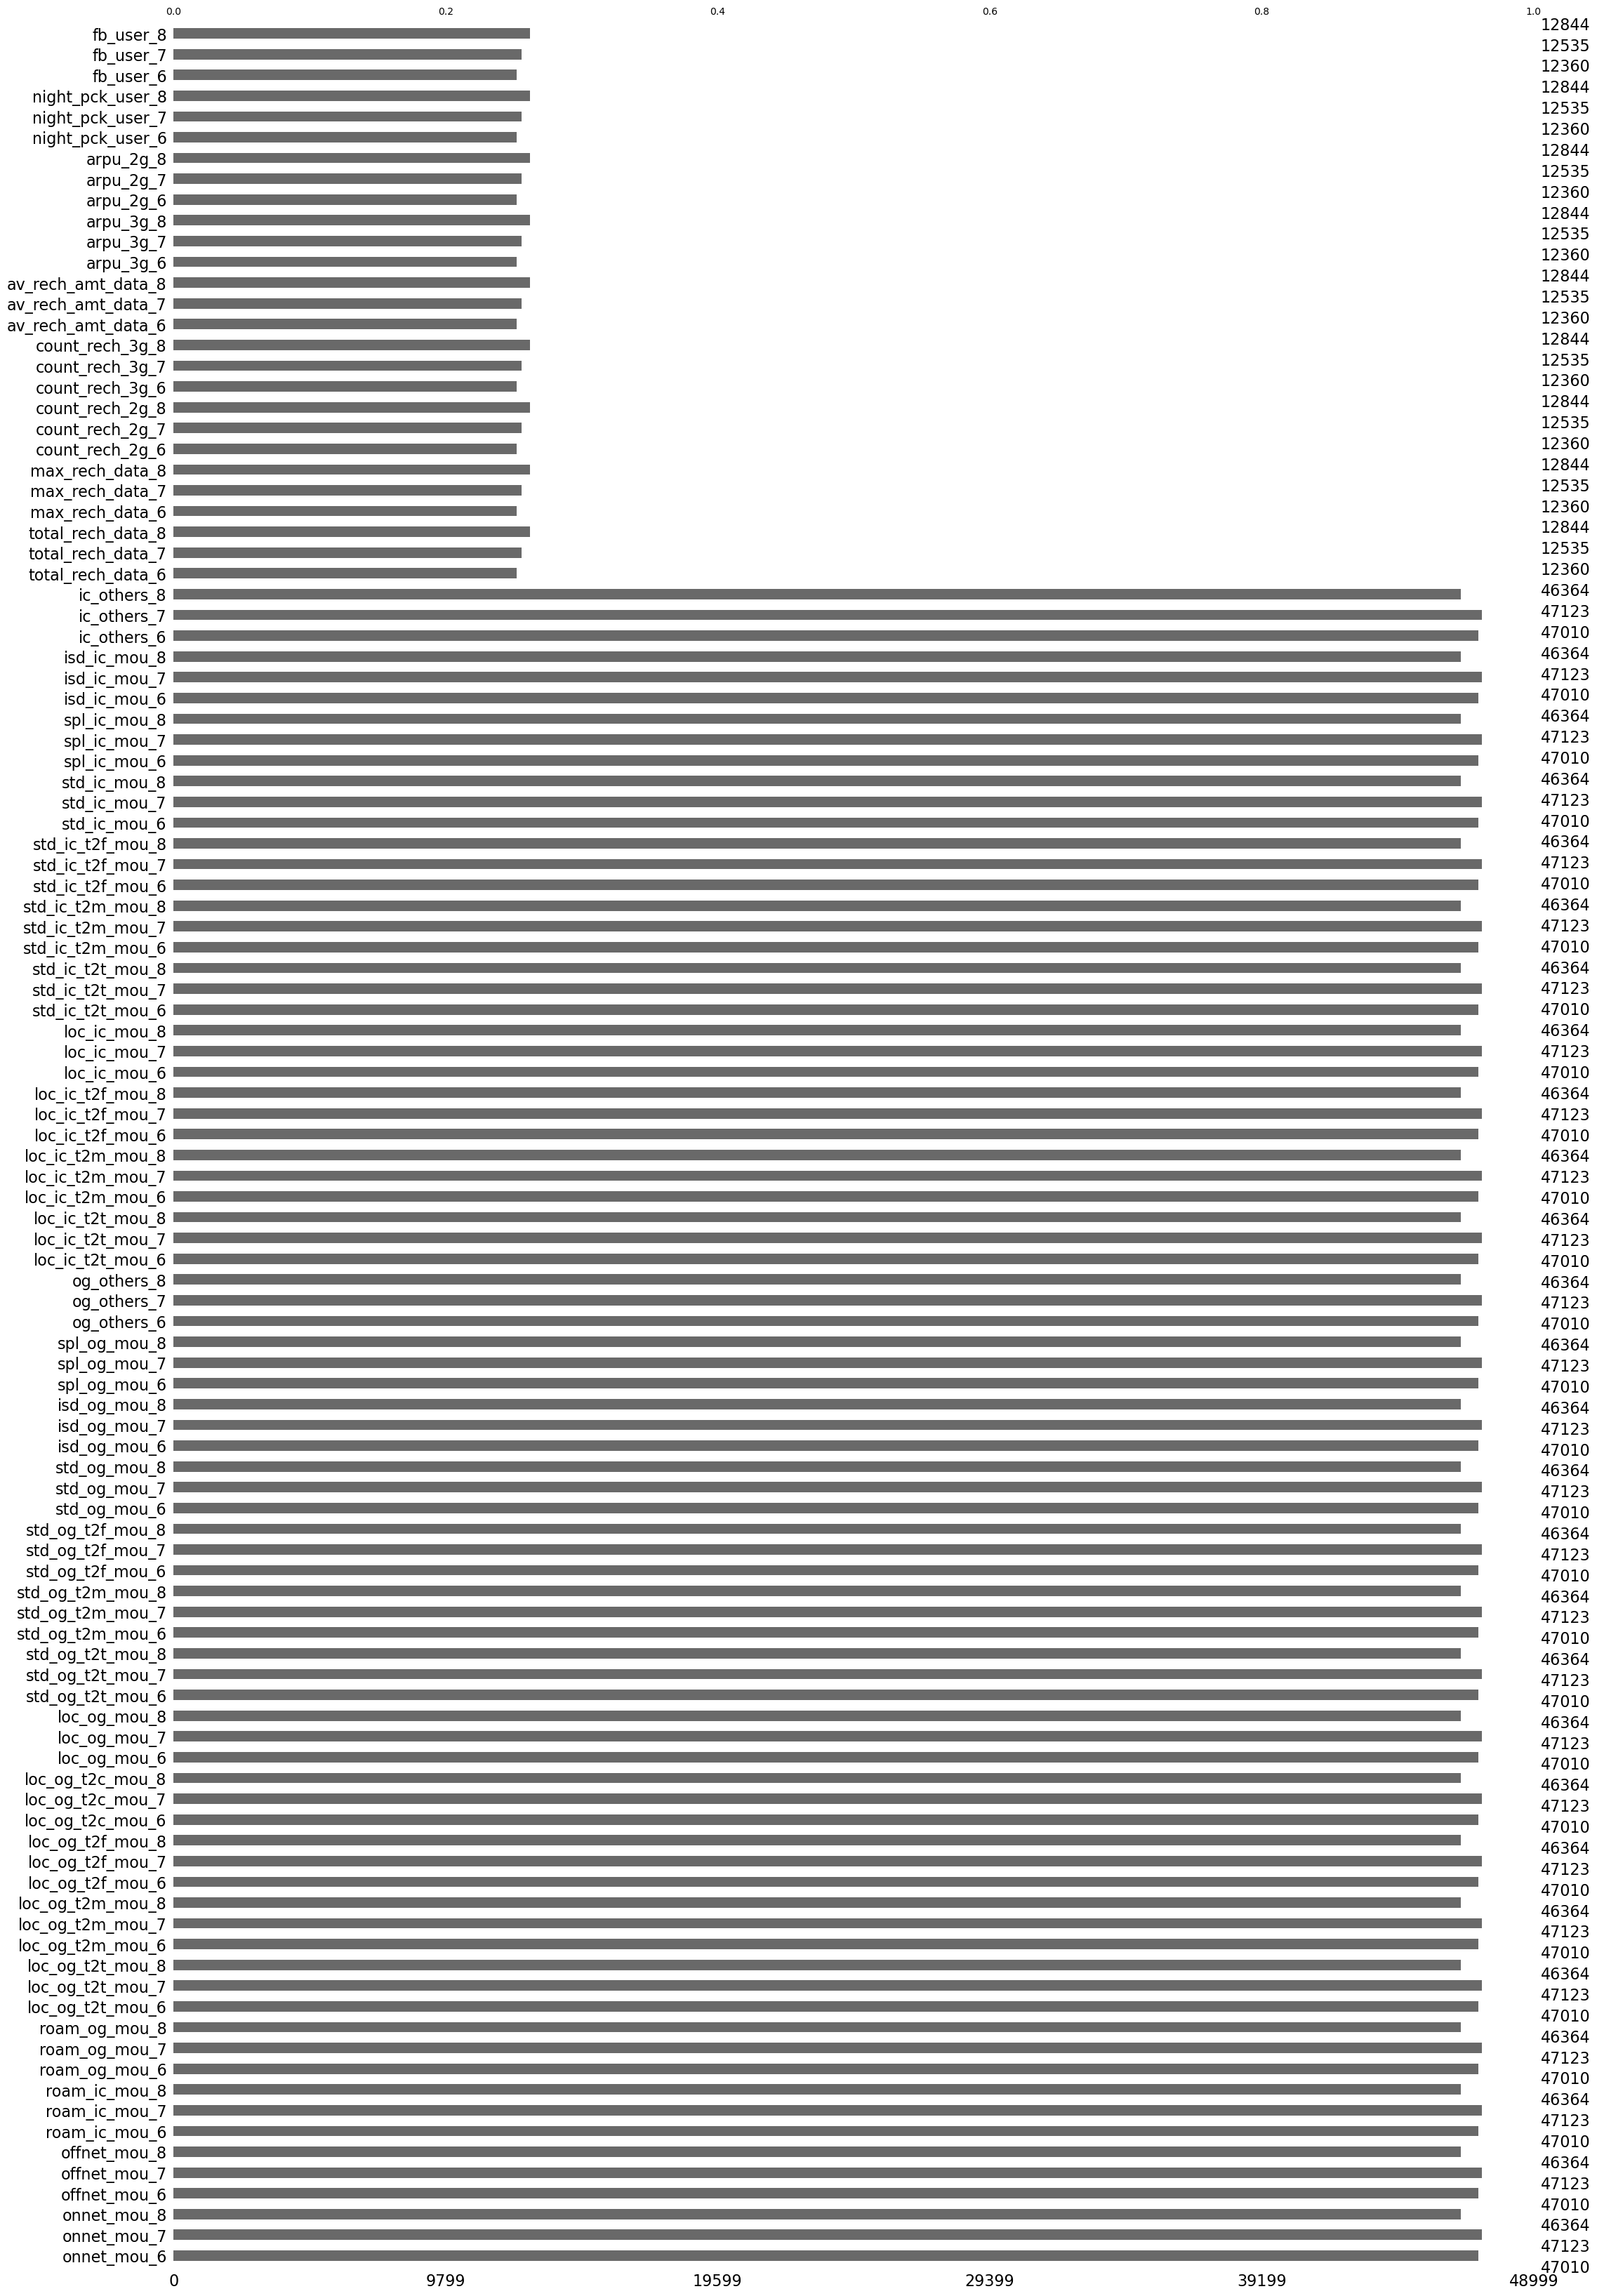

In [338]:
msno.bar(df[cols_with_missing_values])

<Axes: >

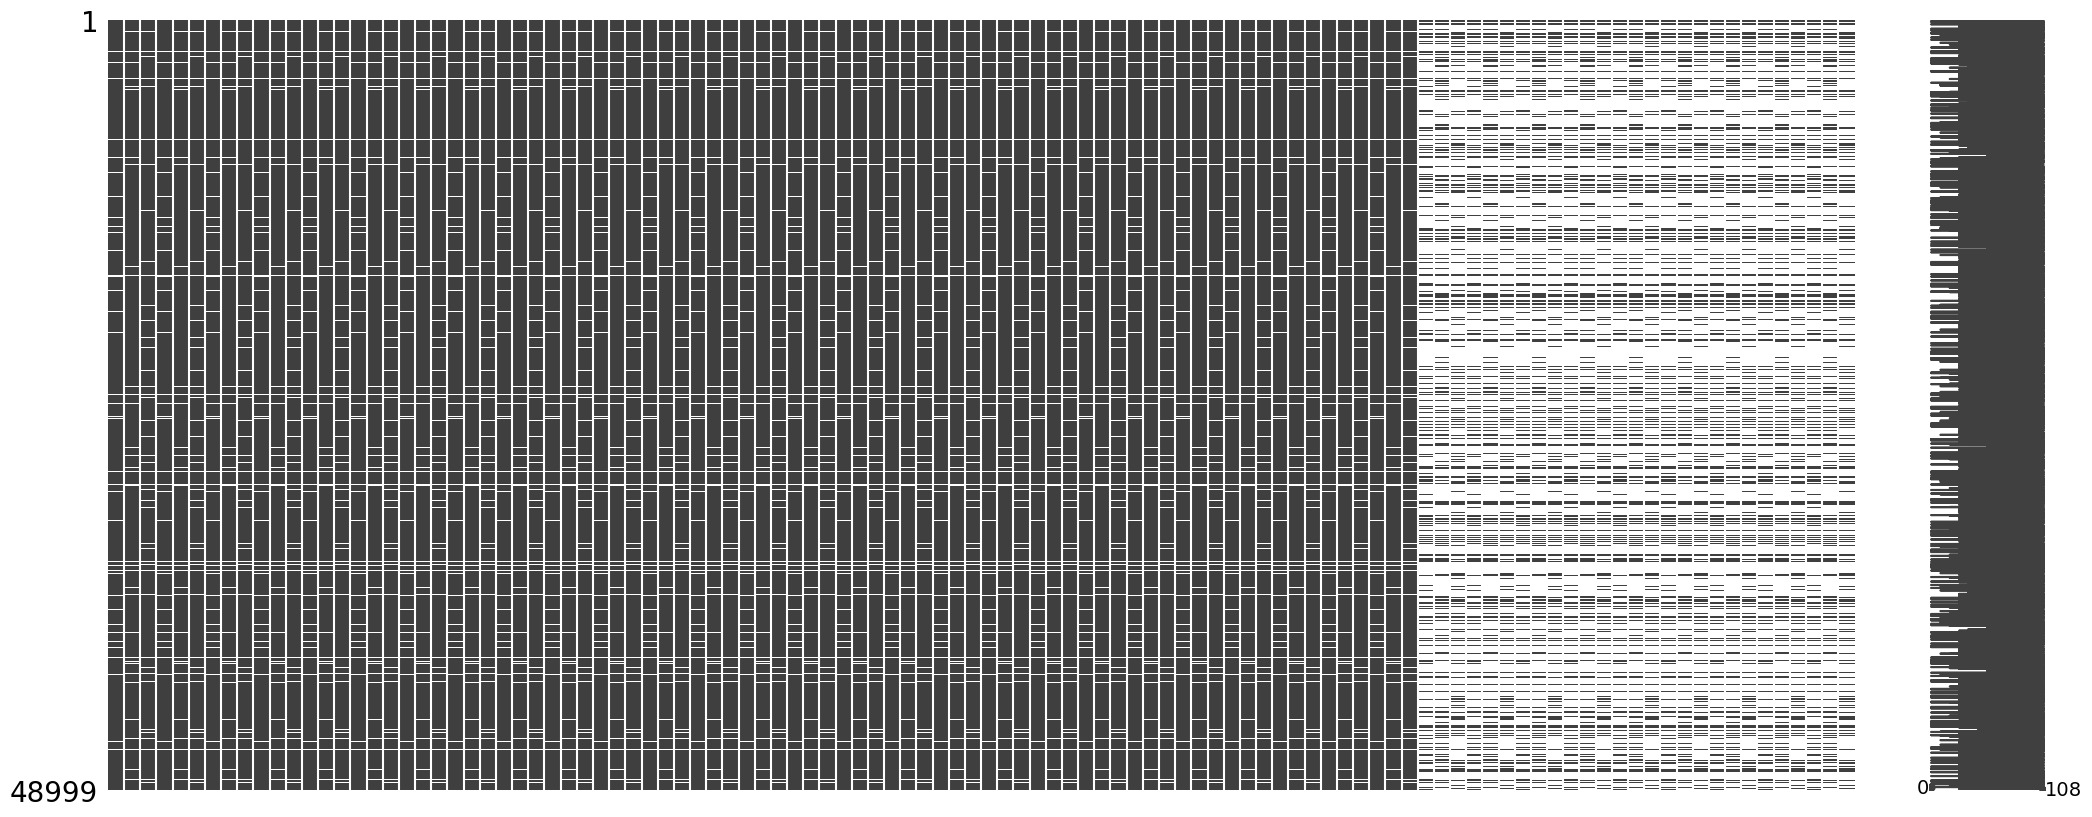

In [339]:
msno.matrix(df[cols_with_missing_values])

## e. Imputing missing values
- When there is no data reacharge then all data related feilds are supposed to be null. We can impute such values as 0.
- Still these columns have high count of missing values so these columns can be dropped
- from remaining we can remove the rows with high count of missing values 

In [341]:
df[high_missing_cols]=df[high_missing_cols].fillna(0)

Imputing all remaining columns with 0 

In [344]:
df=df.fillna(0)

In [348]:
missing_percent=100*df.isnull().sum()/df.churn_probability.count()
missing_percent[missing_percent > 0]

Series([], dtype: float64)

## f. Standardising column names aug_vbc_3g	jul_vbc_3g	jun_vbc_3g

In [351]:
df=df.rename(columns={'jun_vbc_3g': 'vbc_3g_6' , 'jul_vbc_3g':'vbc_3g_7','aug_vbc_3g':'vbc_3g_8'})
df.head()

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,vbc_3g_8,vbc_3g_7,vbc_3g_6,churn_probability
48645,145.463,111.483,223.732,1.81,1.55,1.10,21.68,24.28,15.43,5.26,0.0,0.0,11.29,0.0,0.0,1.26,0.00,1.10,10.93,13.56,15.43,0.00,0.00,0.00,6.75,0.0,0.00,12.19,13.56,16.53,0.00,1.55,0.00,0.00,10.71,0.00,0.00,0.00,0.00,0.00,12.26,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.0,0.0,0.0,12.19,25.83,16.53,0.91,0.00,0.40,10.24,9.29,24.03,0.00,0.00,0.00,11.16,9.29,24.43,1.23,0.00,0.00,0.00,4.06,0.00,0.00,0.00,0.00,1.23,4.06,0.00,12.39,13.36,24.43,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,10,8,11,100,75,125,25,25,25,25,25,25,8.0,6.0,10.0,25.0,25.0,25.0,8.0,6.0,9.0,0.0,0.0,1.0,200.0,150.0,250.0,75.44,52.17,39.68,139.01,203.06,407.54,4.83,0.0,109.06,3.0,1.2,24.11,0.0,0.0,0.0,0,0,0,8,6,9,0,0,0,0,0,1,1.0,1.0,1.0,1145,322.79,231.01,171.3,0
54979,107.101,31.592,106.170,49.44,46.19,68.96,25.83,19.78,38.04,3.46,0.0,0.0,14.39,0.0,0.0,36.91,46.19,68.96,18.21,14.11,6.03,1.10,0.00,1.41,0.00,0.0,0.00,56.23,60.31,76.41,0.00,0.00,0.00,4.41,3.35,19.15,0.00,0.00,0.00,4.41,3.35,19.15,0.00,0.00,0.0,0.23,2.31,11.44,0.0,0.0,0.0,60.88,65.98,107.01,255.03,354.11,295.91,70.76,59.04,60.74,16.31,18.14,26.11,342.11,431.31,382.78,0.00,0.00,0.00,67.94,55.03,106.18,0.00,0.00,0.00,67.94,55.03,106.18,410.13,486.76,489.09,0.06,0.41,0.13,0.0,0.0,0.0,0.0,0.0,0.0,5,4,1,110,220,0,110,110,0,0,110,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,768,0.00,0.00,0.0,0
7134,721.506,611.158,553.857,480.79,550.99,413.29,503.23,573.94,498.79,0.00,0.0,0.0,0.00,0.0,0.0,245.06,180.33,187.36,479.73,489.34,476.21,3.11,0.86,2.81,0.00,0.0,0.76,727.91,670.54,666.39,235.73,370.66,225.93,15.33,82.01,18.99,1.03,1.40,0.00,252.09,454.08,244.93,0.28,0.31,0.0,3.73,0.00,0.76,0.0,0.0,0.0,984.03,1124.94,912.09,37.59,34.74,33.69,212.09,189.69,207.74,

# 4. Data understanding

## a. Target Variable

In [355]:
churned=df['churn_probability'].value_counts()[1]
total=df['churn_probability'].count()
churned_percent=100*churned/total
churned_percent

10.271638196697891

# 5. Feature Engineering
- Monthly columns are not useful in model as data will keep on updating. So we need to create baseline and delta columns
- creating delta columns to show change in usage pattern 
- baseline = (usage in month 6 + usage in month 7) / 2
- delta = usage in month 8 - baseline

## a. create Baseline and Delta columns

In [359]:
col_list=[col[:-2] for col in df.columns if col.endswith("_6")]
print("columns with monthly data : ")
print(col_list)
print("--------------------------")
remaining_col_list=[col for col in df.columns if not col.endswith(("_6","_7","8")) ]
print("Remaining columns : ")
print(remaining_col_list)

columns with monthly data : 
['arpu', 'onnet_mou', 'offnet_mou', 'roam_ic_mou', 'roam_og_mou', 'loc_og_t2t_mou', 'loc_og_t2m_mou', 'loc_og_t2f_mou', 'loc_og_t2c_mou', 'loc_og_mou', 'std_og_t2t_mou', 'std_og_t2m_mou', 'std_og_t2f_mou', 'std_og_mou', 'isd_og_mou', 'spl_og_mou', 'og_others', 'total_og_mou', 'loc_ic_t2t_mou', 'loc_ic_t2m_mou', 'loc_ic_t2f_mou', 'loc_ic_mou', 'std_ic_t2t_mou', 'std_ic_t2m_mou', 'std_ic_t2f_mou', 'std_ic_mou', 'total_ic_mou', 'spl_ic_mou', 'isd_ic_mou', 'ic_others', 'total_rech_num', 'total_rech_amt', 'max_rech_amt', 'last_day_rch_amt', 'total_rech_data', 'max_rech_data', 'count_rech_2g', 'count_rech_3g', 'av_rech_amt_data', 'vol_2g_mb', 'vol_3g_mb', 'arpu_3g', 'arpu_2g', 'night_pck_user', 'monthly_2g', 'sachet_2g', 'monthly_3g', 'sachet_3g', 'fb_user', 'vbc_3g']
--------------------------
Remaining columns : 
['aon', 'churn_probability']


In [361]:
df_new=df[remaining_col_list]

In [363]:
for col in col_list:
    df_new[col + '_baseline'] = ( df[col + '_6'] + df[col + '_7'] ) /2 
    df_new[col + '_delta'] = df[col + '_8'] - df_new[col + '_baseline']

In [365]:
df_new.head()

,aon,churn_probability,arpu_baseline,arpu_delta,onnet_mou_baseline,onnet_mou_delta,offnet_mou_baseline,offnet_mou_delta,roam_ic_mou_baseline,roam_ic_mou_delta,roam_og_mou_baseline,roam_og_mou_delta,loc_og_t2t_mou_baseline,loc_og_t2t_mou_delta,loc_og_t2m_mou_baseline,loc_og_t2m_mou_delta,loc_og_t2f_mou_baseline,loc_og_t2f_mou_delta,loc_og_t2c_mou_baseline,loc_og_t2c_mou_delta,loc_og_mou_baseline,loc_og_mou_delta,std_og_t2t_mou_baseline,std_og_t2t_mou_delta,std_og_t2m_mou_baseline,std_og_t2m_mou_delta,std_og_t2f_mou_baseline,std_og_t2f_mou_delta,std_og_mou_baseline,std_og_mou_delta,isd_og_mou_baseline,isd_og_mou_delta,spl_og_mou_baseline,spl_og_mou_delta,og_others_baseline,og_others_delta,total_og_mou_baseline,total_og_mou_delta,loc_ic_t2t_mou_baseline,loc_ic_t2t_mou_delta,loc_ic_t2m_mou_baseline,loc_ic_t2m_mou_delta,loc_ic_t2f_mou_baseline,loc_ic_t2f_mou_delta,loc_ic_mou_baseline,loc_ic_mou_delta,std_ic_t2t_mou_baseline,std_ic_t2t_mou_delta,std_ic_t2m_mou_baseline,std_ic_t2m_mou_delta,std_ic_t2f_mou_baseline,std_ic_t2f_mou_delta,std_ic_mou_baseline,std_ic_mou_delta,total_ic_mou_baseline,total_ic_mou_delta,spl_ic_mou_baseline,spl_ic_mou_delta,isd_ic_mou_baseline,isd_ic_mou_delta,ic_others_baseline,ic_others_delta,total_rech_num_baseline,total_rech_num_delta,total_rech_amt_baseline,total_rech_amt_delta,max_rech_amt_baseline,max_rech_amt_delta,last_day_rch_amt_baseline,last_day_rch_amt_delta,total_rech_data_baseline,total_rech_data_delta,max_rech_data_baseline,max_rech_data_delta,count_rech_2g_baseline,count_rech_2g_delta,count_rech_3g_baseline,count_rech_3g_delta,av_rech_amt_data_baseline,av_rech_amt_data_delta,vol_2g_mb_baseline,vol_2g_mb_delta,vol_3g_mb_baseline,vol_3g_mb_delta,arpu_3g_baseline,arpu_3g_delta,arpu_2g_baseline,arpu_2g_delta,night_pck_user_baseline,night_pck_user_delta,monthly_2g_baseline,monthly_2g_delta,sachet_2g_baseline,sachet_2g_delta,monthly_3g_baseline,monthly_3g_delta,sachet_3g_baseline,sachet_3g_delta,fb_user_baseline,fb_user_delta,vbc_3g_baseline,vbc_3g_delta
48645,1145,0,128.4730,95.2590,1.680,-0.580,22.980,-7.550,2.63,-2.63,5.645,-5.645,0.630,0.470,12.245,3.185,0.000,0.000,3.375,-3.375,12.875,3.655,0.775,-0.775,5.355,-5.355,0.000,0.000,6.130,-6.130,0.000,0.000,0.000,0.000,0.0,0.0,19.010,-2.480,0.455,-0.055,9.765,14.265,0.000,0.000,10.225,14.205,0.615,-0.615,2.030,-2.030,0.000,0.000,2.645,-2.645,12.875,11.555,0.000,0.000,0.0,0.0,0.0,0.0,9.0,2.0,87.5,37.5,25.0,0.0,25.0,0.0,7.0,3.0,25.0,0.0,7.0,2.0,0.0,1.0,175.0,75.0,63.805,-24.125,171.035,236.505,2.415,106.645,2.1,22.01,0.0,0.0,0.0,0.0,7.0,2.0,0.0,0.0,0.0,1.0,1.0,0.0,201.155,121.635
54979,768,0,69.3465,36.8235,47.815,21.145,22.805,15.235,1.73,-1.73,7.195,-7.195,41.550,27.410,16.160,-10.130,0.550,0.860,0.000,0.000,58.270,18.140,0.000,0.000,3.880,15.270,0.000,0.000,3.880,15.270,0.000,0.000,1.270,10.170,0.0,0.0,63.430,43.580,304.570,-8.660,64.900,-4.160,17.225,8.885,386.710,-3.930,0.000,0.000,61.485,44.695,0.000,0.000,61.485,44.695,448.445,40.645,0.235,-0.105,0.0,0.0,0.0,0.0,4.5,-3.5,165.0,-165.0,110.0,-110.0,55.0,-55.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000
7134,3386,0,666.3320,-112.4750,515.890,-102.600,538.585,-39.795,0.00,0.00,0.000,0.000,212.695,-25.335,484.535,-8.325,1.985,0.825,0.000,0.760,699.225,-32.835,303.195,-77.265,48.670,-29.680,1.215,-1.215,353.085,-108.155,0.295,-0.295,1.865,-1.105,0.0,0.0,1054.485,-142.395,36.165,-2.475,200.890,6.850,42.900,-10.270,279.975,-5.895,9.995,-6.085,25.535,-14.305,5.955,-5.545,41.495,-25.935,321.475,-31.835,0.000,0.000,0.0,0.0,0.0,0.0,10.5,1.5,717.5,-50.5,119.0,31.0,65.0,-65.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000
6361,1254,0,90.5070,106.0930,11.035,28.655,42.345,161.445,0.00,0.00,0.000,0.000,11.035,15.555,35.370,81.260,0.000,5.590,0.000,0.000,46.410,102.420,0.000,13.090,6.970,74.590,0.000,0.000,6.970,87.

# scaling features 
- so that it works well with all algorithms

In [368]:
scaling_cols=df_new.columns
scaler=MinMaxScaler()
df_new[scaling_cols]=scaler.fit_transform(df_new[scaling_cols])

In [370]:
df_new.head()

,aon,churn_probability,arpu_baseline,arpu_delta,onnet_mou_baseline,onnet_mou_delta,offnet_mou_baseline,offnet_mou_delta,roam_ic_mou_baseline,roam_ic_mou_delta,roam_og_mou_baseline,roam_og_mou_delta,loc_og_t2t_mou_baseline,loc_og_t2t_mou_delta,loc_og_t2m_mou_baseline,loc_og_t2m_mou_delta,loc_og_t2f_mou_baseline,loc_og_t2f_mou_delta,loc_og_t2c_mou_baseline,loc_og_t2c_mou_delta,loc_og_mou_baseline,loc_og_mou_delta,std_og_t2t_mou_baseline,std_og_t2t_mou_delta,std_og_t2m_mou_baseline,std_og_t2m_mou_delta,std_og_t2f_mou_baseline,std_og_t2f_mou_delta,std_og_mou_baseline,std_og_mou_delta,isd_og_mou_baseline,isd_og_mou_delta,spl_og_mou_baseline,spl_og_mou_delta,og_others_baseline,og_others_delta,total_og_mou_baseline,total_og_mou_delta,loc_ic_t2t_mou_baseline,loc_ic_t2t_mou_delta,loc_ic_t2m_mou_baseline,loc_ic_t2m_mou_delta,loc_ic_t2f_mou_baseline,loc_ic_t2f_mou_delta,loc_ic_mou_baseline,loc_ic_mou_delta,std_ic_t2t_mou_baseline,std_ic_t2t_mou_delta,std_ic_t2m_mou_baseline,std_ic_t2m_mou_delta,std_ic_t2f_mou_baseline,std_ic_t2f_mou_delta,std_ic_mou_baseline,std_ic_mou_delta,total_ic_mou_baseline,total_ic_mou_delta,spl_ic_mou_baseline,spl_ic_mou_delta,isd_ic_mou_baseline,isd_ic_mou_delta,ic_others_baseline,ic_others_delta,total_rech_num_baseline,total_rech_num_delta,total_rech_amt_baseline,total_rech_amt_delta,max_rech_amt_baseline,max_rech_amt_delta,last_day_rch_amt_baseline,last_day_rch_amt_delta,total_rech_data_baseline,total_rech_data_delta,max_rech_data_baseline,max_rech_data_delta,count_rech_2g_baseline,count_rech_2g_delta,count_rech_3g_baseline,count_rech_3g_delta,av_rech_amt_data_baseline,av_rech_amt_data_delta,vol_2g_mb_baseline,vol_2g_mb_delta,vol_3g_mb_baseline,vol_3g_mb_delta,arpu_3g_baseline,arpu_3g_delta,arpu_2g_baseline,arpu_2g_delta,night_pck_user_baseline,night_pck_user_delta,monthly_2g_baseline,monthly_2g_delta,sachet_2g_baseline,sachet_2g_delta,monthly_3g_baseline,monthly_3g_delta,sachet_3g_baseline,sachet_3g_delta,fb_user_baseline,fb_user_delta,vbc_3g_baseline,vbc_3g_delta
48645,0.233148,0.0,0.018193,0.315064,0.000253,0.527303,0.003696,0.204327,0.000859,0.384196,0.002342,0.439868,0.000106,0.422400,0.002950,0.578532,0.000000,0.365543,0.007353,0.637551,0.002146,0.414943,0.000117,0.528595,0.000875,0.211333,0.000000,0.599525,0.000908,0.305966,0.000000,0.530967,0.000000,0.591360,0.0,0.583131,0.002785,0.307463,0.000062,0.330385,0.002304,0.435433,0.000000,0.443574,0.001346,0.367327,0.000163,0.590663,0.000767,0.388118,0.000000,0.476048,0.000496,0.419938,0.001691,0.462743,0.000000,0.495888,0.0,0.636286,0.0,0.517085,0.073469,0.600000,0.002317,0.296763,0.007578,0.445303,0.008065,0.497161,0.12844,0.478571,0.016077,0.455913,0.181818,0.523810,0.0,0.417476,0.03403,0.494725,0.013184,0.368407,0.004664,0.493179,0.002879,0.394609,0.002218,0.448830,0.0,0.5,0.0,0.416667,0.184211,0.528302,0.0,0.461538,0.0,0.401869,1.0,0.5,0.024559,0.402563
54979,0.142063,0.0,0.016339,0.311915,0.007195,0.529467,0.003668,0.205765,0.000565,0.384439,0.002984,0.439584,0.006993,0.425873,0.003894,0.575845,0.001112,0.366748,0.000000,0.643198,0.009713,0.416779,0.000000,0.528671,0.000634,0.212615,0.000000,0.599525,0.000575,0.307134,0.000000,0.530967,0.000827,0.596918,0.0,0.583131,0.009293,0.309961,0.041607,0.329506,0.015311,0.433118,0.009695,0.448330,0.050899,0.365599,0.000000,0.590789,0.023225,0.399416,0.000000,0.476048,0.011519,0.427996,0.058890,0.465096,0.014148,0.492690,0.0,0.636286,0.0,0.517085,0.036735,0.562712,0.004369,0.286810,0.033343,0.419536,0.017742,0.488240,0.00000,0.435714,0.000000,0.455913,0.000000,0.485714,0.0,0.398058,0.00000,0.474175,0.000000,0.370292,0.000000,0.483938,0.002330,0.376726,0.001740,0.443829,0.0,0.5,0.0,0.416667,0.000000,0.490566,0.0,0.461538,0.0,0.383178,0.0,0.5,0.000000,0.392439
7134,0.774583,0.0,0.035059,0.303872,0.077631,0.517143,0.086627,0.202293,0.000000,0.384907,0.000000,0.440900,0.035798,0.419074,0.116751,0.576209,0.004013,0.366699,0.000000,0.644470,0.116557,0.410318,0.045675,0.521094,0.007949,0.209821,0.003173,0.597207,0.05228

# 7. Identifying Impactful features
- In all models we need to give more weightage to Class : churn_probability=1 as its % in entire data is just 10%
- using tree model identify top 20 features
- similarly using RFE

In [373]:
y_train=df_new['churn_probability']
X_train=df_new.drop(columns=['churn_probability'])

## using smote

In [376]:
smote = SMOTE(sampling_strategy='minority', random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [378]:
print(X_train.shape,y_train.shape)
print(X_train.shape,y_train.shape)

(87932, 101) (87932,)
(87932, 101) (87932,)


## using PCA

Explained Variance Ratio: 0.9831372736674895


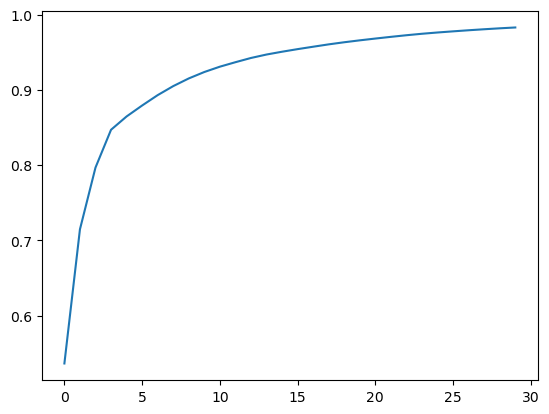

In [381]:
pca = PCA(n_components=30)  # Reduce to 2 principal components
X_train_pca = pca.fit_transform(X_train)

# Step 3: Display explained variance
print("Explained Variance Ratio:", pca.explained_variance_ratio_.sum())
cumulative_var=np.cumsum(pca.explained_variance_ratio_)
plt.plot(cumulative_var)
plt.show()

In [382]:
from sklearn.decomposition import IncrementalPCA
pca=IncrementalPCA(n_components=20)
X_train_pca=pca.fit_transform(X_train)

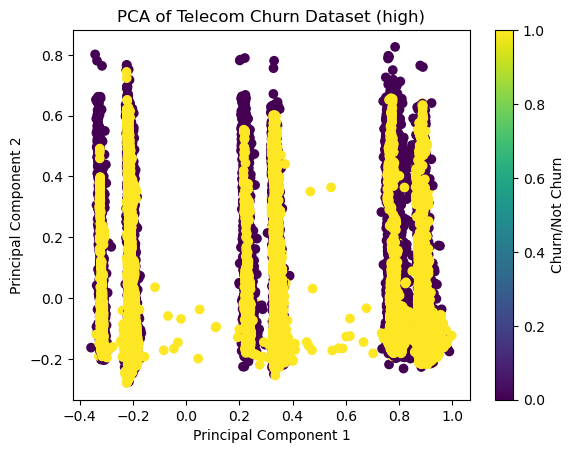

In [383]:
# Step 4: Visualize the transformed data
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Telecom Churn Dataset (high)')
plt.colorbar(label='Churn/Not Churn')
plt.show()

## a. Changes required on Test Data
This class encapsulates all the important variables which we decided as part of model training. 
It uses this information to do required transformation on test data and predict results.
This class would be given to clients to process their raw data and predict churn. 

## b. Classes for managing multiple dataset and multiple models

### i. Class to store params identified from training

In [58]:
class Subparams :
    def __init__(self):
        self.scaler=None
        self.scaling_cols=None
        self.unique_cols=None
        self.scale_pos_weight=None
        self.pca=None
        
    def summary(self):
        print("\n scaling_cols \n",self.scaling_cols)
        print("\n unique_features\n",self.unique_cols)
        print("\n scale_pos_weight\n",self.scale_pos_weight)

class TrainingOutputParams :
    def __init__(self) :
        self.target = None
        self.timeseries_col_list=None
        self.remaining_col_list = None
        self.revenue_threshold_value = None
        self.revenue_threshold_column = None
        self.scaler=None
        self.scaling_cols=None
        self.unique_cols=None
        self.scale_pos_weight=None
        self.pca=None
        
                
    def summary(self):
        params_df = pd.DataFrame(list(params.__dict__.items()), columns=['Variable', 'Value'])
        display(HTML(params_df.to_html(index=False)))
      

params=TrainingOutputParams()

In [429]:
params.target = 'churn_probability'
params.timeseries_col_list=col_list
params.remaining_col_list = remaining_col_list + ['id']
params.pca=pca
params.scaling_cols=scaling_cols
params.scaler=scaler

print(params.summary())

Variable,Value
target,churn_probability
timeseries_col_list,"[arpu, onnet_mou, offnet_mou, roam_ic_mou, roam_og_mou, loc_og_t2t_mou, loc_og_t2m_mou, loc_og_t2f_mou, loc_og_t2c_mou, loc_og_mou, std_og_t2t_mou, std_og_t2m_mou, std_og_t2f_mou, std_og_mou, isd_og_mou, spl_og_mou, og_others, total_og_mou, loc_ic_t2t_mou, loc_ic_t2m_mou, loc_ic_t2f_mou, loc_ic_mou, std_ic_t2t_mou, std_ic_t2m_mou, std_ic_t2f_mou, std_ic_mou, total_ic_mou, spl_ic_mou, isd_ic_mou, ic_others, total_rech_num, total_rech_amt, max_rech_amt, last_day_rch_amt, total_rech_data, max_rech_data, count_rech_2g, count_rech_3g, av_rech_amt_data, vol_2g_mb, vol_3g_mb, arpu_3g, arpu_2g, night_pck_user, monthly_2g, sachet_2g, monthly_3g, sachet_3g, fb_user, vbc_3g]"
remaining_col_list,"[aon, churn_probability, id]"
revenue_threshold_value,None
revenue_threshold_column,None
scaler,MinMaxScaler()
scaling_cols,"Index(['aon', 'churn_probability', 'arpu_baseline', 'arpu_delta', 'onnet_mou_baseline', 'onnet_mou_delta', 'offnet_mou_baseline', 'offnet_mou_delta', 'roam_ic_mou_baseline', 'roam_ic_mou_delta', ... 'sachet_2g_baseline', 'sachet_2g_delta', 'monthly_3g_baseline', 'monthly_3g_delta', 'sachet_3g_baseline', 'sachet_3g_delta', 'fb_user_baseline', 'fb_user_delta', 'vbc_3g_baseline', 'vbc_3g_delta'], dtype='object', length=102)"
unique_cols,None
scale_pos_weight,None
pca,IncrementalPCA(n_components=20)


### ii. Data represents High/Regular

In [63]:
class Data :
    def __init__(self,df,target,params) :
        print(params.summary())
        self.df=df
        self.scaler=params.scaler
        self.scaling_cols=params.scaling_cols
        self.target=target
        self.pca=params.pca
        self.X=None
        self.y=None
        self.preprocessData()
        self.splitData()
    
    def summary(self):
        print("\n Data: df: ", None if self.df is None else self.df.shape)
        print("\n Data: X: ", None if self.X is None else self.X.shape)
        print("\n Data: y: ", None if self.y is None else self.y.shape)

    def preprocessData(self):
        self.df[self.scaling_cols]=self.scaler.transform(self.df[self.scaling_cols])
        
    def splitData(self):
        self.y=self.df[self.target]
        self.X=self.df.drop(columns=[self.target])
        self.X=self.pca.transform(self.X.drop(columns=['id']))

### iii. Datasets like training,test,unseen

In [66]:
class Dataset : 
    def __init__(self,df,params):
        self.df_complete=df
        self.data=None
        self.prepared_data=None
        self.params=params
        self.preprocessData()
        self.summary()
        
    def summary(self):
        print("\n Dataset:df_complete: ", None if self.df_complete is None else self.df_complete.shape)
        self.data.summary()

    def preprocessData(self):
        # Standardising column names 
        self.df_complete=self.df_complete.rename(columns={'jun_vbc_3g': 'vbc_3g_6' , 'jul_vbc_3g':'vbc_3g_7','aug_vbc_3g':'vbc_3g_8'})

        # Imputing missing values with 0 
        self.df_complete=self.df_complete.fillna(0)
        
        self.prepared_data=self.df_complete[self.params.remaining_col_list]
        for col in self.params.timeseries_col_list:
            self.prepared_data[col + '_baseline'] = ( self.df_complete[col + '_6'] + self.df_complete[col + '_7'] ) /2 
            self.prepared_data[col + '_delta'] = self.df_complete[col + '_8'] - self.prepared_data[col + '_baseline']
        self.data=Data(self.prepared_data,self.params.target,self.params)


### c. All Datasets

#### ii. Test dataset

In [433]:
train=Dataset(df_train,params)


target: 
 churn_probability

timeseries_col_list: 
 ['arpu', 'onnet_mou', 'offnet_mou', 'roam_ic_mou', 'roam_og_mou', 'loc_og_t2t_mou', 'loc_og_t2m_mou', 'loc_og_t2f_mou', 'loc_og_t2c_mou', 'loc_og_mou', 'std_og_t2t_mou', 'std_og_t2m_mou', 'std_og_t2f_mou', 'std_og_mou', 'isd_og_mou', 'spl_og_mou', 'og_others', 'total_og_mou', 'loc_ic_t2t_mou', 'loc_ic_t2m_mou', 'loc_ic_t2f_mou', 'loc_ic_mou', 'std_ic_t2t_mou', 'std_ic_t2m_mou', 'std_ic_t2f_mou', 'std_ic_mou', 'total_ic_mou', 'spl_ic_mou', 'isd_ic_mou', 'ic_others', 'total_rech_num', 'total_rech_amt', 'max_rech_amt', 'last_day_rch_amt', 'total_rech_data', 'max_rech_data', 'count_rech_2g', 'count_rech_3g', 'av_rech_amt_data', 'vol_2g_mb', 'vol_3g_mb', 'arpu_3g', 'arpu_2g', 'night_pck_user', 'monthly_2g', 'sachet_2g', 'monthly_3g', 'sachet_3g', 'fb_user', 'vbc_3g']

remaining_col_list : 
 ['aon', 'churn_probability', 'id']

 scaling_cols 
 Index(['aon', 'churn_probability', 'arpu_baseline', 'arpu_delta',
       'onnet_mou_baseline', 'on

In [435]:
#Test dataset
test=Dataset(df_test,params)


target: 
 churn_probability

timeseries_col_list: 
 ['arpu', 'onnet_mou', 'offnet_mou', 'roam_ic_mou', 'roam_og_mou', 'loc_og_t2t_mou', 'loc_og_t2m_mou', 'loc_og_t2f_mou', 'loc_og_t2c_mou', 'loc_og_mou', 'std_og_t2t_mou', 'std_og_t2m_mou', 'std_og_t2f_mou', 'std_og_mou', 'isd_og_mou', 'spl_og_mou', 'og_others', 'total_og_mou', 'loc_ic_t2t_mou', 'loc_ic_t2m_mou', 'loc_ic_t2f_mou', 'loc_ic_mou', 'std_ic_t2t_mou', 'std_ic_t2m_mou', 'std_ic_t2f_mou', 'std_ic_mou', 'total_ic_mou', 'spl_ic_mou', 'isd_ic_mou', 'ic_others', 'total_rech_num', 'total_rech_amt', 'max_rech_amt', 'last_day_rch_amt', 'total_rech_data', 'max_rech_data', 'count_rech_2g', 'count_rech_3g', 'av_rech_amt_data', 'vol_2g_mb', 'vol_3g_mb', 'arpu_3g', 'arpu_2g', 'night_pck_user', 'monthly_2g', 'sachet_2g', 'monthly_3g', 'sachet_3g', 'fb_user', 'vbc_3g']

remaining_col_list : 
 ['aon', 'churn_probability', 'id']

 scaling_cols 
 Index(['aon', 'churn_probability', 'arpu_baseline', 'arpu_delta',
       'onnet_mou_baseline', 'on

#### iii. Unseen dataset

In [441]:
unseen_df['churn_probability']=0
unseen_df.head()

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
0,69999,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,91.882,65.330,64.445,31.78,20.23,23.11,60.16,32.16,34.83,0.00,0.00,0.00,0.00,0.00,0.00,24.88,20.23,21.06,18.13,10.89,8.36,0.00,13.58,0.00,0.0,0.00,0.03,43.01,44.71,29.43,6.90,0.00,2.05,42.03,7.68,26.43,0.0,0.0,0.0,0.0,0.0,0.0,48.93,7.68,28.48,0.0,0.0,0.0,0.00,0.00,0.03,0.0,0.0,0.0,91.94,52.39,57.94,30.33,37.56,21.98,10.21,4.59,9.53,0.26,0.00,0.00,40.81,42.16,31.51,0.00,0.00,0.00,0.36,1.04,4.34,0.0,0.0,0.00,0.0,0.0,0.0,0.36,1.04,4.34,41.73,43.56,36.26,0.54,0.34,0.39,0.00,0.00,0.00,0.0,0.0,0.00,5,5,4,103,90,60,50,30,30,6/21/2014,7/26/2014,8/24/2014,30,30,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,1692,0.00,0.00,0.00,0
1,70000,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,414.168,515.568,360.868,75.51,41.21,19.84,474.34,621.84,394.94,0.00,0.00,0.00,0.00,0.00,0.00,75.51,41.21,19.84,473.61,598.08,377.26,0.73,0.00,0.00,0.0,0.00,0.00,549.86,639.29,397.11,0.00,0.00,0.00,0.00,23.76,17.68,0.0,0.0,0.0,0.0,0.0,0.0,0.00,23.76,17.68,0.0,0.0,0.8,0.00,0.00,0.00,0.0,0.0,0.0,549.86,663.06,415.59,19.99,26.95,2.61,160.19,122.29,184.81,1.49,0.00,0.00,181.69,149.24,187.43,0.00,0.00,0.00,0.00,12.51,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.00,12.51,0.00,296.33,339.64,281.66,0.00,0.00,0.00,114.63,177.88,94.23,0.0,0.0,0.00,5,4,5,500,500,500,250,250,250,6/19/2014,7/16/2014,8/24/201

In [443]:
# unseen dataset 
unseen=Dataset(unseen_df,params)


target: 
 churn_probability

timeseries_col_list: 
 ['arpu', 'onnet_mou', 'offnet_mou', 'roam_ic_mou', 'roam_og_mou', 'loc_og_t2t_mou', 'loc_og_t2m_mou', 'loc_og_t2f_mou', 'loc_og_t2c_mou', 'loc_og_mou', 'std_og_t2t_mou', 'std_og_t2m_mou', 'std_og_t2f_mou', 'std_og_mou', 'isd_og_mou', 'spl_og_mou', 'og_others', 'total_og_mou', 'loc_ic_t2t_mou', 'loc_ic_t2m_mou', 'loc_ic_t2f_mou', 'loc_ic_mou', 'std_ic_t2t_mou', 'std_ic_t2m_mou', 'std_ic_t2f_mou', 'std_ic_mou', 'total_ic_mou', 'spl_ic_mou', 'isd_ic_mou', 'ic_others', 'total_rech_num', 'total_rech_amt', 'max_rech_amt', 'last_day_rch_amt', 'total_rech_data', 'max_rech_data', 'count_rech_2g', 'count_rech_3g', 'av_rech_amt_data', 'vol_2g_mb', 'vol_3g_mb', 'arpu_3g', 'arpu_2g', 'night_pck_user', 'monthly_2g', 'sachet_2g', 'monthly_3g', 'sachet_3g', 'fb_user', 'vbc_3g']

remaining_col_list : 
 ['aon', 'churn_probability', 'id']

 scaling_cols 
 Index(['aon', 'churn_probability', 'arpu_baseline', 'arpu_delta',
       'onnet_mou_baseline', 'on